<a href="https://colab.research.google.com/github/iher9812/IMF/blob/main/Caso_pr%C3%A1ctico_m2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado



Cada día es más frecuente la introducción de la ciencia de datos en el ámbito del derecho y la justicia. Un ejemplo bien conocido de ello es el sistema COMPAS (Correctional offender management profiling for alternative sanctions) que se usa en varios estados de los Estados Unidos para hacer una evaluación del riesgo de reincidencia de las personas detenidas. Una breve descripción del sistema puede verse en la página https://en.wikipedia.org/wiki/COMPAS_(software).



En este caso, proporciona un conjunto de datos en bruto con información de las evaluaciones (fichero compas-scores.csv) y la historia legal de unos 11 000 casos en los años 2013 y 2014 (se trata de uno de los ficheros originales utilizados en un análisis independiente del sistema COMPAS llevado a cabo por ProPublica, disponible en internet). Aunque el conjunto de datos contiene información adicional, para resolver las cuestiones planteadas en este caso son necesarios (aparte de algunos campos cuyo nombre es autoexplicativo) los siguientes campos:



“compas_screening_date”: se refiere a la fecha en la que se realizó la evaluación
“decile_score”: es un número, de 1 a 10 que indica el riesgo de reincidencia en general (a mayor riesgo, mayor número).
“v_decile_score”: es un número de 1 a 10, potencialmente distinto del anterior, que indica el riesgo de reincidencia en delitos violentos. Al hacer la evaluación de un caso en COMPAS, se generan las dos puntuaciones (entre otras cosas).
“is_recid”: indicación de si la persona es reincidente (en el tiempo en que se recogen datos: no hay información de si la persona es reincidente más allá de ciertas fechas, y es importante tener esto en cuenta para asegurarse de hacer comparaciones homogéneas).
“r_offense_date”: fecha en la que se cometió el delito por el que se considera reincidente a la persona.
“is_violent_recid”: indicación de si la persona es reincidente en un delito con violencia (las mismas consideraciones sobre fechas que para “is_recid” aplican aquí)".
“vr_offense_date”: fecha en la que se cometió el delito violento que da lugar a la consideración de reincidente.

## Se pide



1 - Cargar los datos y realizar un análisis exploratorio y una evaluación de la calidad de los datos necesarios para el resto del caso. Específicamente, evaluar la integridad, validez y actualidad de los datos y proponer estrategias de mitigación de los posibles problemas encontrados.



2 - ¿Son los campos “is_recid” e “is_violent_recid” en este conjunto de datos adecuados para evaluar la precisión de las estimaciones de riesgo generadas por el sistema COMPAS? Si no es así, definir y calcular una feature que sí lo sea.



3 - El umbral para establecer medidas preventivas de la reincidencia es de 7 en adelante. Dado este umbral, generar una tabla de contingencia, explicando qué caso se considera como “positivo” (y, por lo tanto, cuáles son los errores de tipo I y los errores de tipo II).



4 - El sistema asigna, de media, evaluaciones de riesgo más altas a los hombres que a las mujeres, y a las personas de raza afroamericana que a las de raza caucásica. Sin embargo, también las tasas de reincidencia son más altas para esos colectivos, aunque no está claro que la asignación de riesgo sea “justa” o no. Mostrar estas diferencias mediante representaciones gráficas y utilizarlas para analizar si la asignación de evaluaciones es justa o no.

  

5 - ¿Para qué tipo de riesgos, el de delitos generales o el de delitos violentos, tiene el sistema más capacidad predictiva?

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Configurar la visualización
sns.set(style="whitegrid")

### 1. Cargar los datos y realizar un análisis exploratorio

In [3]:
# 1. Cargar los datos y realizar un análisis exploratorio
df = pd.read_csv('/content/compas-scores.csv')


In [4]:
# Análisis exploratorio y calidad de los datos
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

   id              name    first       last compas_screening_date   sex  \
0   1  miguel hernandez   miguel  hernandez            2013-08-14  Male   
1   2      michael ryan  michael       ryan            2014-12-31  Male   
2   3       kevon dixon    kevon      dixon            2013-01-27  Male   
3   4          ed philo       ed      philo            2013-04-14  Male   
4   5       marcu brown    marcu      brown            2013-01-13  Male   

          dob  age          age_cat              race  ...  vr_offense_date  \
0  1947-04-18   69  Greater than 45             Other  ...              NaN   
1  1985-02-06   31          25 - 45         Caucasian  ...              NaN   
2  1982-01-22   34          25 - 45  African-American  ...       2013-07-05   
3  1991-05-14   24     Less than 25  African-American  ...              NaN   
4  1993-01-21   23     Less than 25  African-American  ...              NaN   

                vr_charge_desc  v_type_of_assessment  v_decile_score  \
0 

In [5]:
# Evaluación de la integridad y validez de los datos
integrity_issues = df.isnull().sum().sum() > 0
validity_issues = df[['decile_score', 'v_decile_score']].apply(lambda x: ((x < 1) | (x > 10)).sum())

In [6]:
# Evaluación de la actualidad de los datos
date_columns = ['compas_screening_date', 'r_offense_date', 'vr_offense_date']
df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')
date_issues = df[date_columns].isnull().sum()

In [7]:
# Propuesta de estrategias de mitigación
if integrity_issues:
    print("Datos faltantes detectados. Estrategia propuesta: Imputación de la media/moda o eliminación de las filas.")
if validity_issues.sum() > 0:
    print("Valores no válidos en los puntajes. Estrategia propuesta: Normalizar valores fuera del rango esperado a los límites.")
if date_issues.sum() > 0:
    print("Fechas no válidas detectadas. Estrategia propuesta: Imputación o eliminación de registros con fechas faltantes.")


Datos faltantes detectados. Estrategia propuesta: Imputación de la media/moda o eliminación de las filas.
Valores no válidos en los puntajes. Estrategia propuesta: Normalizar valores fuera del rango esperado a los límites.
Fechas no válidas detectadas. Estrategia propuesta: Imputación o eliminación de registros con fechas faltantes.


### 2. Evaluar si "is_recid" e "is_violent_recid" son adecuados para evaluar la precisión de las estimaciones

In [10]:
# 2. Evaluar si "is_recid" e "is_violent_recid" son adecuados para evaluar la precisión de las estimaciones
# Definir una nueva feature "is_correctly_classified" que evalúe si la evaluación coincide con la reincidencia real
threshold = 7
df['predicted_recid'] = df['decile_score'] >= threshold

In [11]:
# Asegurarse de que 'is_recid' está presente en el DataFrame
df['is_recid'] = df['is_recid'].fillna(0).astype(int)
df['is_correctly_classified'] = df['predicted_recid'] == df['is_recid']


In [12]:
# Verificación de las proporciones de coincidencia entre "predicted_recid" y "is_recid"
correct_classification_rate = df['is_correctly_classified'].mean()
print(f"Tasa de clasificación correcta: {correct_classification_rate:.2f}")

Tasa de clasificación correcta: 0.63


### 3. Generar una tabla de contingencia para el umbral de 7 en adelante


In [13]:
# 3. Generar una tabla de contingencia para el umbral de 7 en adelante
conf_matrix = confusion_matrix(df['is_recid'], df['predicted_recid'])

In [15]:
# Ajustar los índices y columnas según el tamaño de la matriz de confusión
if conf_matrix.shape == (2, 2):
    index_labels = ["Real Negativo", "Real Positivo"]
    column_labels = ["Predicho Negativo", "Predicho Positivo"]
else:
    index_labels = [f"Real {i}" for i in range(conf_matrix.shape[0])]
    column_labels = [f"Predicho {i}" for i in range(conf_matrix.shape[1])]

print("Tabla de Contingencia:")
print(pd.DataFrame(conf_matrix, index=index_labels, columns=column_labels))

Tabla de Contingencia:
        Predicho 0  Predicho 1  Predicho 2
Real 0           0         572         147
Real 1           0        5877        1458
Real 2           0        2200        1503


### 4. Analizar si la asignación de evaluaciones es justa

In [16]:
# 4. Analizar si la asignación de evaluaciones es justa
gender_risk = df.groupby('sex')['decile_score'].mean()
race_risk = df.groupby('race')['decile_score'].mean()


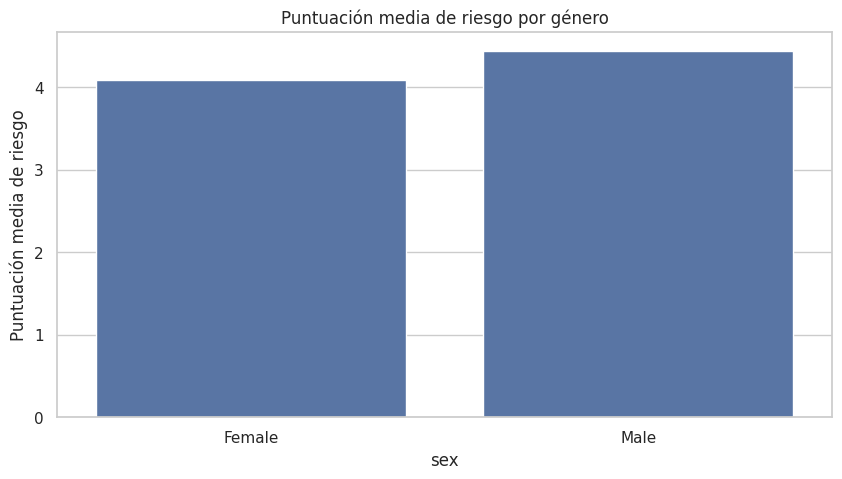

In [17]:
# Visualización de las diferencias entre hombres y mujeres
plt.figure(figsize=(10, 5))
sns.barplot(x=gender_risk.index, y=gender_risk.values)
plt.title("Puntuación media de riesgo por género")
plt.ylabel("Puntuación media de riesgo")
plt.show()


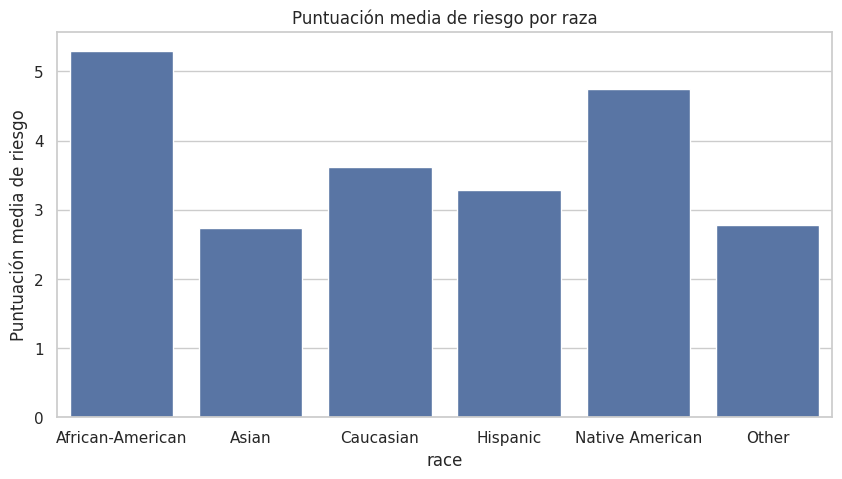

In [18]:
# Visualización de las diferencias entre diferentes razas
plt.figure(figsize=(10, 5))
sns.barplot(x=race_risk.index, y=race_risk.values)
plt.title("Puntuación media de riesgo por raza")
plt.ylabel("Puntuación media de riesgo")
plt.show()

In [19]:
# Tasa de reincidencia por grupo
gender_recid = df.groupby('sex')['is_recid'].mean()
race_recid = df.groupby('race')['is_recid'].mean()

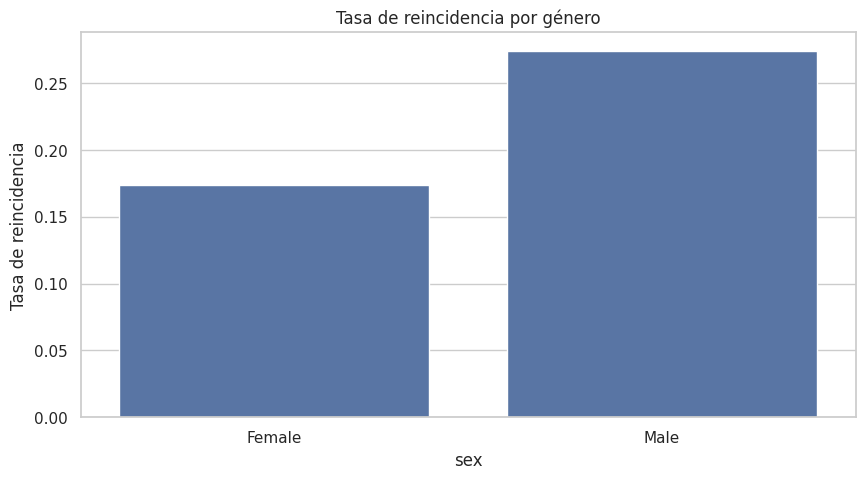

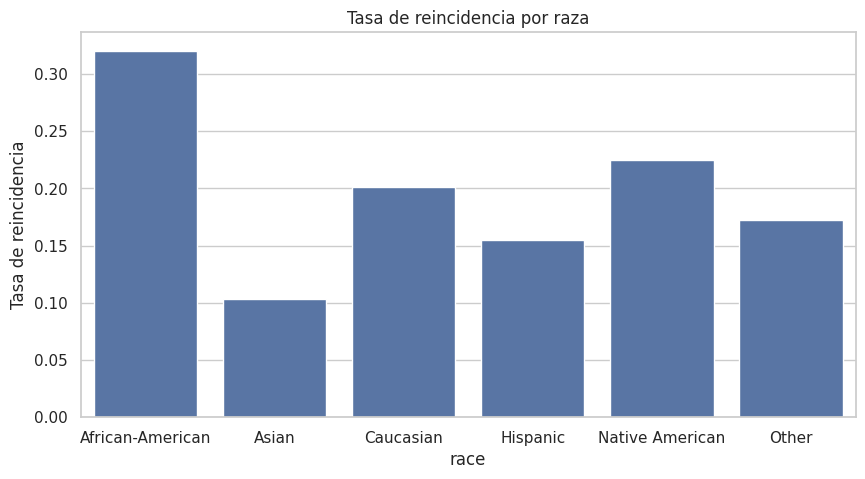

In [21]:
# Visualización de las tasas de reincidencia
plt.figure(figsize=(10, 5))
sns.barplot(x=gender_recid.index, y=gender_recid.values)
plt.title("Tasa de reincidencia por género")
plt.ylabel("Tasa de reincidencia")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=race_recid.index, y=race_recid.values)
plt.title("Tasa de reincidencia por raza")
plt.ylabel("Tasa de reincidencia")
plt.show()

### 5. Comparar la capacidad predictiva para delitos generales vs. violentos

In [24]:
# 5. Comparar la capacidad predictiva para delitos generales vs. violentos
df['predicted_violent_recid'] = df['v_decile_score'] >= threshold
violent_conf_matrix = confusion_matrix(df['is_violent_recid'], df['predicted_violent_recid'])

In [25]:
# Calcular las métricas de evaluación para reincidencia general y reincidencia violenta
general_accuracy = accuracy_score(df['is_recid'], df['predicted_recid'])
violent_accuracy = accuracy_score(df['is_violent_recid'], df['predicted_violent_recid'])

print(f"Precisión para delitos generales: {general_accuracy:.2f}")
print(f"Precisión para delitos violentos: {violent_accuracy:.2f}")

if general_accuracy > violent_accuracy:
    print("El sistema tiene mayor capacidad predictiva para delitos generales.")
else:
    print("El sistema tiene mayor capacidad predictiva para delitos violentos.")

Precisión para delitos generales: 0.63
Precisión para delitos violentos: 0.82
El sistema tiene mayor capacidad predictiva para delitos violentos.
